# Custom experiments

In [1]:
import pybamm

## Custom termination

Termination of a step can be specified using a few standard strings (e.g. "4.2V" for voltage, "1 A" for current, "C/2" for C-rate), or via a custom termination step. The custom termination step can be specified based on any variable in the model.
Below, we show an example where we specify a custom termination step based on keeping the anode potential above 0V, which is a common limit used to avoid lithium plating,

In [2]:
# Set up model and parameters
model = pybamm.lithium_ion.DFN()
# add anode potential as a variable
# we use the potential at the separator interface since that is the minimum potential
# during charging (plating is most likely to occur first at the separator interface)
model.variables["Anode potential [V]"] = model.variables[
    "Negative electrode surface potential difference at separator interface [V]"
]
parameter_values = pybamm.ParameterValues("Chen2020")


# Create a custom termination event for the anode potential cut-off at 0.02V
# We use 0.02V instead of 0V to give a safety factor
def anode_potential_cutoff(variables):
    return variables["Anode potential [V]"] - 0.02


# The CustomTermination class takes a name and function
anode_potential_termination = pybamm.step.CustomTermination(
    name="Anode potential cut-off [V]", event_function=anode_potential_cutoff
)

# Provide a list of termination events, each step will stop whenever the first
# termination event is reached
terminations = [anode_potential_termination, "4.2V"]

# Set up multi-step CC experiment with the customer terminations followed
# by a voltage hold
experiment = pybamm.Experiment(
    [
        (
            pybamm.step.c_rate(-1, termination=terminations),
            pybamm.step.c_rate(-0.5, termination=terminations),
            pybamm.step.c_rate(-0.25, termination=terminations),
            "Hold at 4.2V until C/50",
        )
    ]
)

# Set up simulation
sim = pybamm.Simulation(model, parameter_values=parameter_values, experiment=experiment)

# for a charge we start as SOC 0
sim.solve(initial_soc=0)

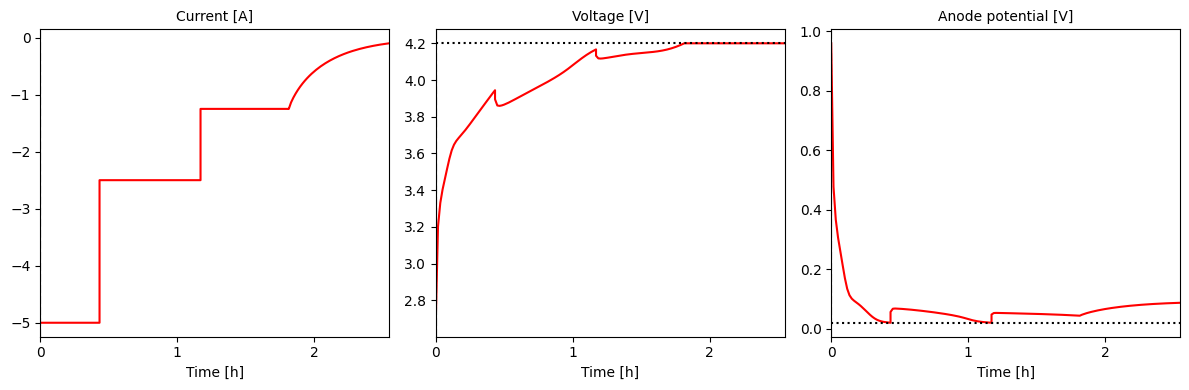

In [3]:
# Plot
plot = pybamm.QuickPlot(
    sim.solution, ["Current [A]", "Voltage [V]", "Anode potential [V]"]
)
plot.plot(0)

# Plot the limits used in the termination events to check they are not surpassed
plot.axes.by_variable("Voltage [V]").axhline(4.2, color="k", linestyle=":")
plot.axes.by_variable("Anode potential [V]").axhline(0.02, color="k", linestyle=":")

We can check which events were reached by each step

In [4]:
for i, step in enumerate(sim.solution.cycles[0].steps):
    print(f"Step {i}: {step.termination}")

Step 0: event: Anode potential cut-off [V] [experiment]
Step 1: event: Anode potential cut-off [V] [experiment]
Step 2: event: Voltage > 4.2 [V] [experiment]
Step 3: event: C-rate cut-off [experiment]


## Custom steps

Custom steps can be defined using either explicit or implicit control. In explicit control, the user specifies the current explicitly as a function of other variables in the model. 

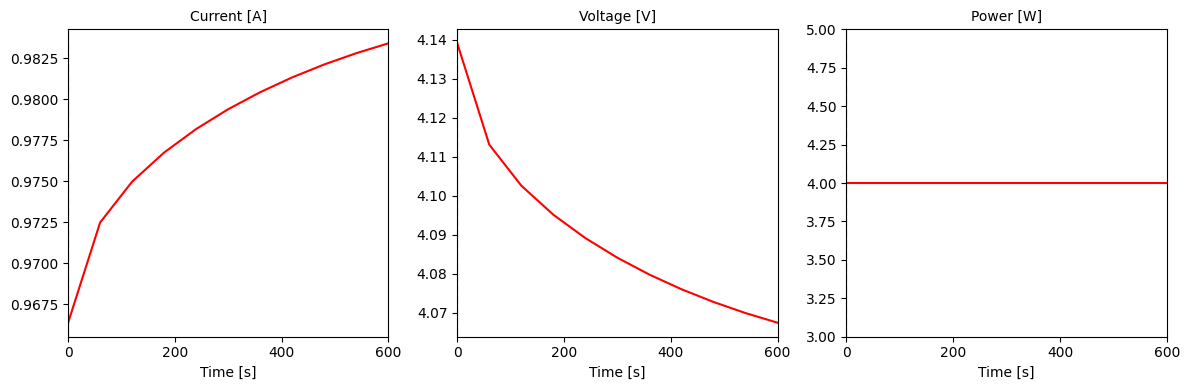

In [5]:
def custom_step_power(variables):
    target_power = 4
    voltage = variables["Voltage [V]"]
    return target_power / voltage


# Run for 10 minutes and plot
step = pybamm.step.CustomStepExplicit(custom_step_power, duration=600)
sol = pybamm.Simulation(
    model, experiment=step, parameter_values=parameter_values
).solve()
pybamm.QuickPlot(sol, ["Current [A]", "Voltage [V]", "Power [W]"]).plot(0)

For custom steps to work with voltage-based termination, we have to specify whether the step is a charge or discharge step. This is done by setting the `direction` attribute of the step to either "charge" or "discharge"

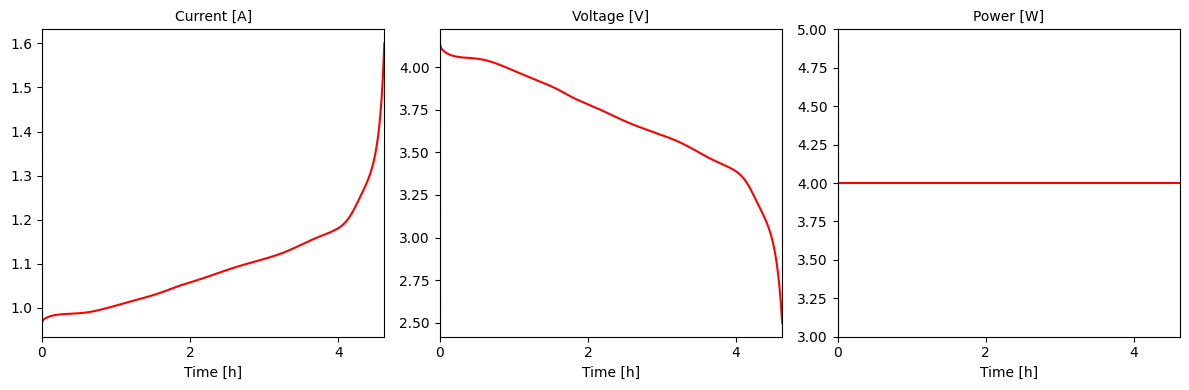

In [6]:
step = pybamm.step.CustomStepExplicit(
    custom_step_power, termination="2.5V", direction="discharge"
)
sol = pybamm.Simulation(
    model, experiment=step, parameter_values=parameter_values
).solve()
pybamm.QuickPlot(sol, ["Current [A]", "Voltage [V]", "Power [W]"]).plot(0)

Be careful not to create an expression that depends on the current itself, as this will lead to a circular dependency. For example, in some models, the voltage is an explicit function of the current, so the user should not create a step that depends on the voltage. An expression that works for one model may not work for another.

We can also specify a custom step using implicit control. This comes with "algebraic" or "differential" control. In algebraic control (the default), the user specifies the equation that must be satisfied at all times, and the model adjusts the current to satisfy this equation. 

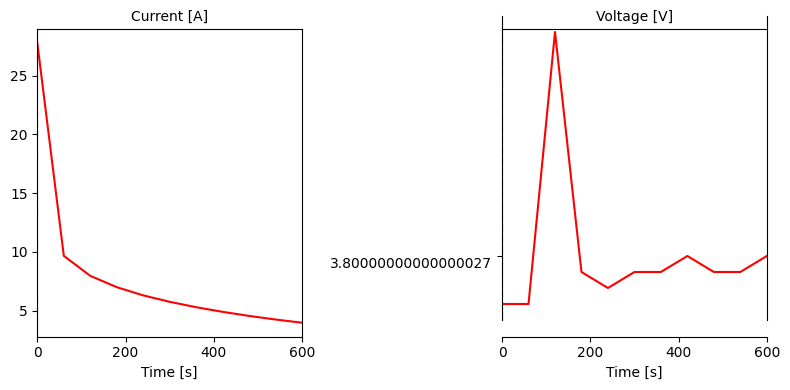

In [7]:
def constant_voltage(variables):
    return variables["Voltage [V]"] - 3.8


step = pybamm.step.CustomStepImplicit(constant_voltage, duration=600)
sol = pybamm.Simulation(
    model, experiment=step, parameter_values=parameter_values
).solve()
pybamm.QuickPlot(sol, ["Current [A]", "Voltage [V]"]).plot(0)

In differential control, the user specifies the derivative of the current.

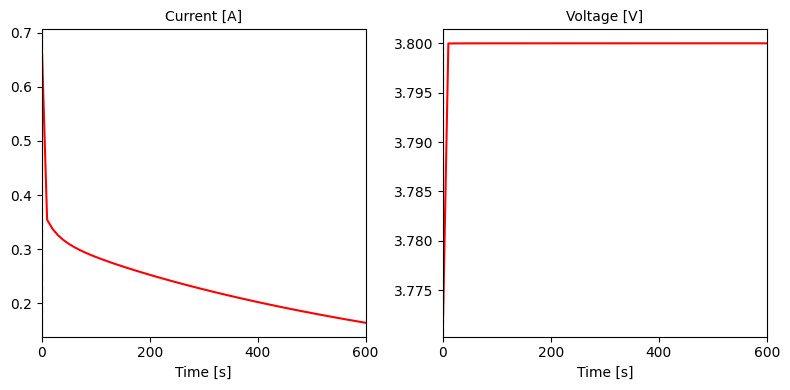

In [8]:
def custom_voltage(variables):
    return 100 * (variables["Voltage [V]"] - 3.8)


step = pybamm.step.CustomStepImplicit(
    custom_voltage, duration=600, period=10, control="differential"
)
sol = pybamm.Simulation(model, experiment=step).solve()
pybamm.QuickPlot(sol, ["Current [A]", "Voltage [V]"]).plot(0)

## Combining custom steps and termination

We now show a full example combining custom steps and termination to charge a battery until the anode potential reaches 0.02V, then ride the 0.02V plateau until the voltage reaches the cut-off voltage, then finish charging with constant voltage

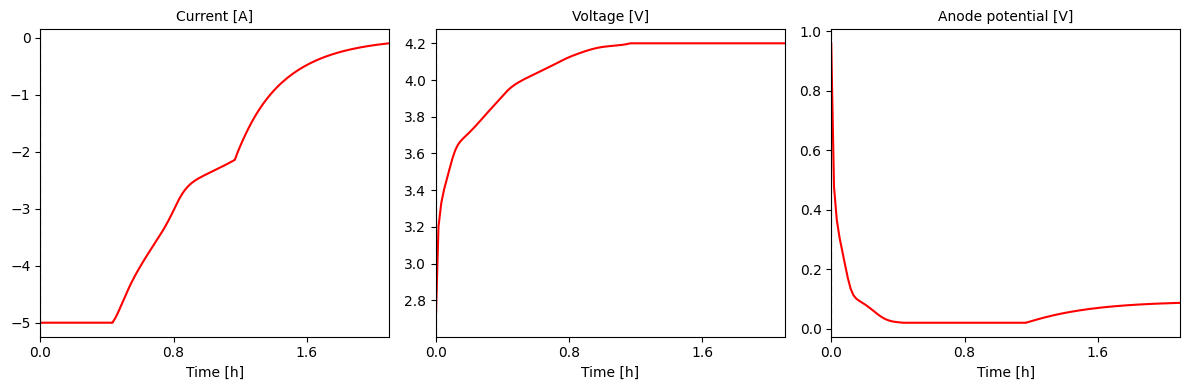

In [9]:
# Create a function for the anode potential cut-off at 0.02V
def anode_potential_cutoff(variables):
    return variables["Anode potential [V]"] - 0.02


# We can reuse the same function to create both the termination event and the step
anode_potential_step = pybamm.step.CustomStepImplicit(
    anode_potential_cutoff, direction="charge", termination="4.2V"
)
anode_potential_termination = pybamm.step.CustomTermination(
    name="Anode potential cut-off [V]", event_function=anode_potential_cutoff
)


# Charge with constant current, then constant anode potential, then constant voltage
def run_experiment(c_rate):
    # Create the experiment
    experiment = pybamm.Experiment(
        [
            (
                # include the 4.2V termination event in case the anode potential cut-off is not reached
                pybamm.step.c_rate(
                    -c_rate, termination=[anode_potential_termination, "4.2V"]
                ),
                anode_potential_step,
                "Hold at 4.2V until C/50",
            )
        ]
    )

    sim = pybamm.Simulation(
        model, parameter_values=parameter_values, experiment=experiment
    )

    # for a charge we start as SOC 0
    sim.solve(initial_soc=0)

    # Plot
    pybamm.QuickPlot(
        sim.solution, ["Current [A]", "Voltage [V]", "Anode potential [V]"]
    ).plot(0)


run_experiment(c_rate=1)

If we never hit the anode potential cut-off, that step is skipped and we go straight to constant voltage

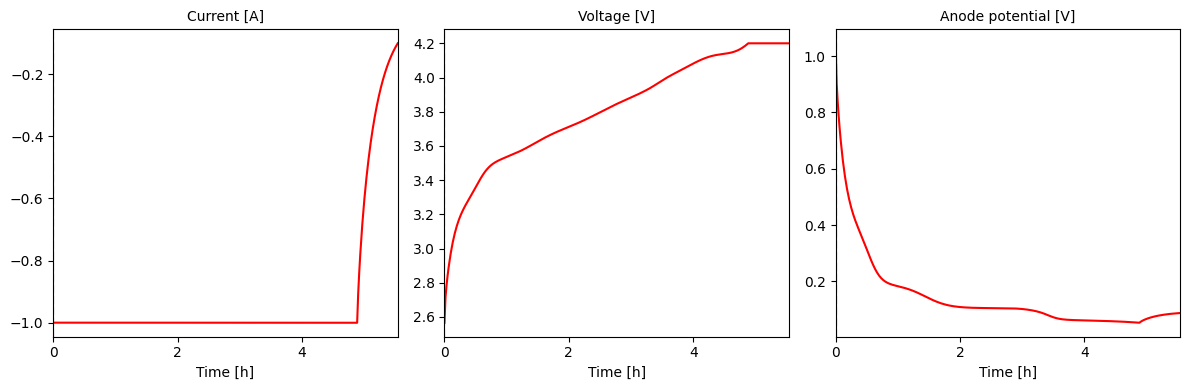

In [10]:
run_experiment(c_rate=0.2)

## References

The relevant papers for this notebook are:

In [11]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Von DAG Bruggeman. Berechnung verschiedener physikalischer konstanten von heterogenen substanzen. i. dielektrizitätskonstanten und leitfähigkeiten der mischkörper aus isotropen substanzen. Annalen der physik, 416(7):636–664, 1935.
[3] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
[4] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. 